In [1]:
from header import*
#import seaborn as sns

plt.rcParams.update({'font.size': 14})

In [7]:
experiment_name = 'MHC'
plots_dir = Path('plots')
df = read_astarix_performance('results/MHC1-astarix-prefix/alignments.tsv')
#df = df.append(read_astarix_performance('results/MHC1-astarix-seeds/alignments.tsv'), ignore_index=True)
df = df.append(read_astarix_performance('results/MHC1-astarix-seeds-bfs/alignments.tsv'), ignore_index=True)

#df = read_astarix_performance('results/ecoli_illumina250_astar-seeds.tsv')
#df = df.append(read_astarix_performance('results/ecoli_illumina250_astar-prefix.tsv'), ignore_index=True)

#df.algo = df.algo.replace(regex=r'astar.*', value='astar')
reads = len(df)
df = df[df.cost <= 8.0]

#display(df.groupby('algo').mean())
display(df.head())
#display(df.groupby('cost').size() / reads)

,ref,refsize,algo,operation,memory,len,read,spell,cost,starts,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped,generated_errors,explored_states,dist
0,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,ATCACATCCAAATCTCACAGGCCTCAAAAGCTACAGCTGACATTCC...,ATCACATCCAAATCTCACAGGCCTCAAAAGCTACAGCTGACATTCC...,0,-1,1.42,0.15,0.0,0.020333,0.000959,1,1.57,-1,142.0,0
1,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,AGAAAAGTACCTCAAAAGGACAAATCTAAGAATGATTGGTGCTCAA...,AGAAAAGTACCTCAAAAGGACAAATCTAAGAATGATTGGTGCTCAA...,0,-1,1.51,0.16,0.0,0.020695,0.017829,1,1.67,-1,151.0,0
2,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,ATGAGAACACATGGACACAGGAAGGGGAACATCACACTCTGGGGAC...,ATGAGAACACATGGACACAGGAAGGGGAACATCACACTCTGGGGAC...,0,-1,4.41,0.54,0.0,0.079559,0.002115,1,4.95,-1,441.0,0
3,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,TAAAGAAATGTGACTCAGTGGTCCACATGGTTGCAGTACCTCCCAT...,TAAAGAAATGTGACTCAGTGGTCCACATGGTTGCAGTACCTCCCAT...,0,-1,2.74,0.23,0.0,0.040670,0.001997,1,2.97,-1,274.0,0
4,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,CATTACTCAGGACAACAGAAGAGAAAGAGCAGGTCTAGAGTGTATA...,CATTACTCAGGACAACAGAAGAGAAAGAGCAGGTCTAGAGTGTATA...,0,-1,1.30,0.15,0.0,0.020289,0.000950,1,1.45,-1,130.0,0


In [10]:
def astar_vs_dijkstra_img(df, x, y, hline, prefix):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F0F0F0')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    # spines
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['algo', x], group_keys=False)[y].mean()
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='algo', values='mean_{}'.format(y))

    z = {}
    for algo in d.columns:
        s = d[algo].dropna()
        z[algo] = np.polyfit(s.index, np.log(s), 1)
    xs = list(d.index)
    d = d.append(df.groupby('algo')[y].mean().rename('all'))
    xs.append(xs[-1]+0.8)  # extrapolation
    
    # Best fit lines
    for algo in d.columns:
        regression_line = []
        a, b = z[algo]
        angle = math.atan2(a, abs(b)) * 180 / math.pi
        for i in xs:
            regression_line.append(np.exp(a*i+b))
        ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo))
        label = '$y \sim x^{{{:0.2f}}}$'.format(np.exp(a))
        ax.text(xs[-1], regression_line[-1], label, #rotation=angle,
                color=algo2color(algo), ha='center', va='bottom', size=16, alpha=1)

    # Times
    for index, row in d.iterrows():
        label = '{0:.3g}x'.format(row["astar-prefix"] / row["astar-seeds"])
        tmp_x = index if index != 'all' else len(d)-1
        tmp_y = np.exp((np.log(row[0]) + np.log(row[1])) / 2)
        ax.text(tmp_x, tmp_y, label, ha='right', va='center', size=12, alpha=0.7)
        
    colors = [algo2color(algo) for algo in d.columns]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    if hline:
        ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 16}, framealpha=0.5)
    else:
        ax.legend(loc="upper left", prop={'size': 16}, framealpha=0.5)

    if hline:
        ax.axhline(df.refsize.median()*df.len.median(), color='k', linestyle='solid', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(max(df[x])+1.7, df.refsize.median()*df.len.median(), 'Total\nstates', ha='left', va='center', size=16)
        
        ax.axhline(y=df.len.median(), color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(max(df[x])+1.7, df.len.median(), 'Lower\nbound', ha='left', va='center', size=16)

    ax.set_yscale('log')
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labels
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.png'), bbox_inches='tight')

In [ ]:
astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix='heuristic_'+experiment_name)
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix='heuristic_'+experiment_name)

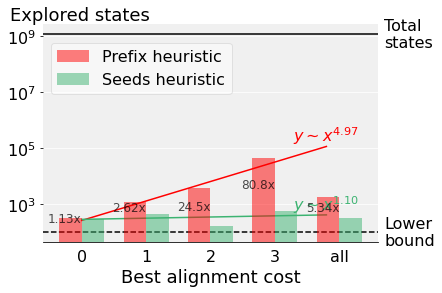

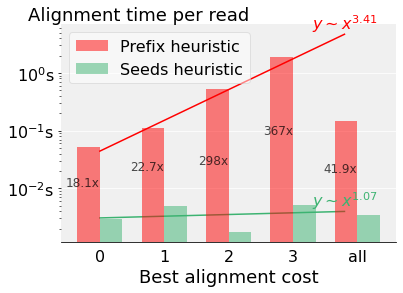

In [14]:
astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix='heuristic_'+experiment_name)
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix='heuristic_'+experiment_name)